(speed)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Numba

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

Please also make sure that you have the latest version of Anaconda, since old
versions are a {doc}`common source of errors <troubleshooting>`.

Let's start with some imports:

In [2]:
%matplotlib inline
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

## Overview

In an {doc}`earlier lecture <need_for_speed>` we learned about vectorization, which is one method to improve speed and efficiency in numerical work.

Vectorization involves sending array processing
operations in batch to efficient low-level code.

However, as {ref}`discussed previously <numba-p_c_vectorization>`, vectorization has several weaknesses.

One is that it is highly memory-intensive when working with large amounts of data.

Another is that the set of algorithms that can be entirely vectorized is not universal.

In fact, for some algorithms, vectorization is ineffective.

Fortunately, a new Python library called [Numba](http://numba.pydata.org/)
solves many of these problems.

It does so through something called **just in time (JIT) compilation**.

The key idea is to compile functions to native machine code instructions on the fly.

When it succeeds, the compiled code is extremely fast.

Numba is specifically designed for numerical work and can also do other tricks such as [multithreading](https://en.wikipedia.org/wiki/Multithreading_%28computer_architecture%29).

Numba will be a key part of our lectures --- especially those lectures involving dynamic programming.

This lecture introduces the main ideas.

(numba_link)=
## {index}`Compiling Functions <single: Compiling Functions>`

```{index} single: Python; Numba
```

As stated above, Numba's primary use is compiling functions to fast native
machine code during runtime.

(quad_map_eg)=
### An Example

Let's consider a problem that is difficult to vectorize: generating the trajectory of a difference equation given an initial condition.

We will take the difference equation to be the quadratic map

$$
x_{t+1} = \alpha x_t (1 - x_t)
$$

In what follows we set

In [3]:
α = 4.0

Here's the plot of a typical trajectory, starting from $x_0 = 0.1$, with $t$ on the x-axis

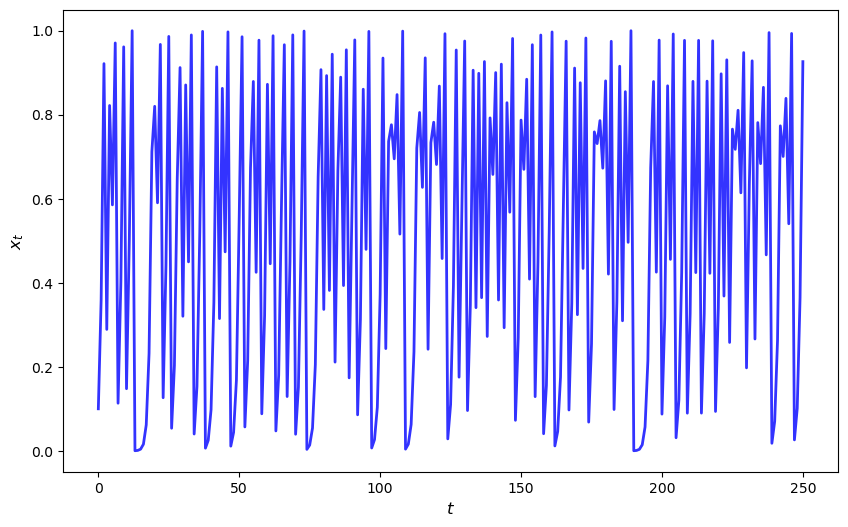

In [4]:
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
      x[t+1] = α * x[t] * (1 - x[t])
    return x

x = qm(0.1, 250)
fig, ax = plt.subplots()
ax.plot(x, 'b-', lw=2, alpha=0.8)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$x_{t}$', fontsize = 12)
plt.show()

To speed the function `qm` up using Numba, our first step is

In [5]:
from numba import jit

qm_numba = jit(qm)

The function `qm_numba` is a version of `qm` that is "targeted" for
JIT-compilation.

We will explain what this means momentarily.

Let's time and compare identical function calls across these two versions, starting with the original function `qm`:

In [6]:
n = 10_000_000

qe.tic()
qm(0.1, int(n))
time1 = qe.toc()

TOC: Elapsed: 0:00:6.28


Now let's try qm_numba

In [7]:
qe.tic()
qm_numba(0.1, int(n))
time2 = qe.toc()

TOC: Elapsed: 0:00:0.26


This is already a massive speed gain.

In fact, the next time and all subsequent times it runs even faster as the function has been compiled and is in memory:

(qm_numba_result)=

In [8]:
qe.tic()
qm_numba(0.1, int(n))
time3 = qe.toc()

TOC: Elapsed: 0:00:0.07


In [9]:
time1 / time3  # Calculate speed gain

84.33804280739231

This kind of speed gain is huge relative to how simple and clear the implementation is.

### How and When it Works

Numba attempts to generate fast machine code using the infrastructure provided by the [LLVM Project](http://llvm.org/).

It does this by inferring type information on the fly.

(See our {doc}`earlier lecture <need_for_speed>` on scientific computing for a discussion of types.)

The basic idea is this:

* Python is very flexible and hence we could call the function qm with many
  types.
    * e.g., `x0` could be a NumPy array or a list, `n` could be an integer or a float, etc.
* This makes it hard to *pre*-compile the function.
* However, when we do actually call the function, say by executing `qm(0.5, 10)`,
  the types of `x0` and `n` become clear.
* Moreover, the types of other variables in `qm` can be inferred once the input is known.
* So the strategy of Numba and other JIT compilers is to wait until this
  moment, and *then* compile the function.

That's why it is called "just-in-time" compilation.

Note that, if you make the call `qm(0.5, 10)` and then follow it with `qm(0.9, 20)`, compilation only takes place on the first call.

The compiled code is then cached and recycled as required.

## Decorators and "nopython" Mode

In the code above we created a JIT compiled version of `qm` via the call

In [10]:
qm_numba = jit(qm)

In practice this would typically be done using an alternative *decorator* syntax.

(We will explain all about decorators in a {doc}`later lecture <python_advanced_features>` but you can skip the details at this stage.)

Let's see how this is done.

### Decorator Notation

To target a function for JIT compilation we can put `@jit` before the function definition.

Here's what this looks like for `qm`

In [11]:
@jit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = α * x[t] * (1 - x[t])
    return x

This is equivalent to `qm = jit(qm)`.

The following now uses the jitted version:

In [12]:
qm(0.1, 10)

array([0.1       , 0.36      , 0.9216    , 0.28901376, 0.82193923,
       0.58542054, 0.97081333, 0.11333925, 0.40197385, 0.9615635 ,
       0.14783656])

### Type Inference and "nopython" Mode

Clearly type inference is a key part of JIT compilation.

As you can imagine, inferring types is easier for simple Python objects (e.g., simple scalar data types such as floats and integers).

Numba also plays well with NumPy arrays.

In an ideal setting, Numba can infer all necessary type information.

This allows it to generate native machine code, without having to call the Python runtime environment.

In such a setting, Numba will be on par with machine code from low-level languages.

When Numba cannot infer all type information, some Python objects are given generic object status and execution falls back to the Python runtime.

When this happens, Numba provides only minor speed gains or none at all.

We generally prefer to force an error when this occurs, so we know effective
compilation is failing.

This is done by using either `@jit(nopython=True)` or, equivalently, `@njit` instead of `@jit`.

For example,

In [13]:
from numba import njit

@njit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

## Compiling Classes

As mentioned above, at present Numba can only compile a subset of Python.

However, that subset is ever expanding.

For example, Numba is now quite effective at compiling classes.

If a class is successfully compiled, then its methods act as JIT-compiled
functions.

To give one example, let's consider the class for analyzing the Solow growth model we
created in {doc}`this lecture <python_oop>`.

To compile this class we use the `@jitclass` decorator:

In [14]:
from numba import float64
from numba.experimental import jitclass

Notice that we also imported something called `float64`.

This is a data type representing standard floating point numbers.

We are importing it here because Numba needs a bit of extra help with types when it trys to deal with classes.

Here's our code:

In [15]:
solow_data = [
    ('n', float64),
    ('s', float64),
    ('δ', float64),
    ('α', float64),
    ('z', float64),
    ('k', float64)
]

@jitclass(solow_data)
class Solow:
    r"""
    Implements the Solow growth model with the update rule

        k_{t+1} = [(s z k^α_t) + (1 - δ)k_t] /(1 + n)

    """
    def __init__(self, n=0.05,  # population growth rate
                       s=0.25,  # savings rate
                       δ=0.1,   # depreciation rate
                       α=0.3,   # share of labor
                       z=2.0,   # productivity
                       k=1.0):  # current capital stock

        self.n, self.s, self.δ, self.α, self.z = n, s, δ, α, z
        self.k = k

    def h(self):
        "Evaluate the h function"
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Apply the update rule
        return (s * z * self.k**α + (1 - δ) * self.k) / (1 + n)

    def update(self):
        "Update the current state (i.e., the capital stock)."
        self.k =  self.h()

    def steady_state(self):
        "Compute the steady state value of capital."
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Compute and return steady state
        return ((s * z) / (n + δ))**(1 / (1 - α))

    def generate_sequence(self, t):
        "Generate and return a time series of length t"
        path = []
        for i in range(t):
            path.append(self.k)
            self.update()
        return path

First we specified the types of the instance data for the class in
`solow_data`.

After that, targeting the class for JIT compilation only requires adding
`@jitclass(solow_data)` before the class definition.

When we call the methods in the class, the methods are compiled just like functions.

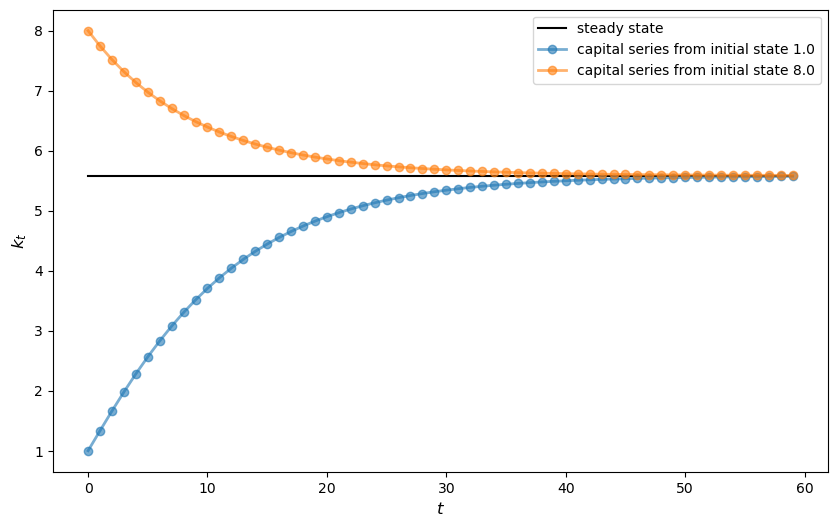

In [16]:
s1 = Solow()
s2 = Solow(k=8.0)

T = 60
fig, ax = plt.subplots()

# Plot the common steady state value of capital
ax.plot([s1.steady_state()]*T, 'k-', label='steady state')

# Plot time series for each economy
for s in s1, s2:
    lb = f'capital series from initial state {s.k}'
    ax.plot(s.generate_sequence(T), 'o-', lw=2, alpha=0.6, label=lb)
ax.set_ylabel('$k_{t}$', fontsize=12)
ax.set_xlabel('$t$', fontsize=12)
ax.legend()
plt.show()

## Alternatives to Numba

```{index} single: Python; Cython
```

There are additional options for accelerating Python loops.

Here we quickly review them.

However, we do so only for interest and completeness.

If you prefer, you can safely skip this section.

### Cython

Like {doc}`Numba <numba>`,  [Cython](http://cython.org/) provides an approach to generating fast compiled code that can be used from Python.

As was the case with Numba, a key problem is the fact that Python is dynamically typed.

As you'll recall, Numba solves this problem (where possible) by inferring type.

Cython's approach is different --- programmers add type definitions directly to their "Python" code.

As such, the Cython language can be thought of as Python with type definitions.

In addition to a language specification, Cython is also a language translator, transforming Cython code into optimized C and C++ code.

Cython also takes care of building language extensions --- the wrapper code that interfaces between the resulting compiled code and Python.

While Cython has certain advantages, we generally find it both slower and more
cumbersome than Numba.

### Interfacing with Fortran via F2Py

```{index} single: Python; Interfacing with Fortran
```

If you are comfortable writing Fortran you will find it very easy to create
extension modules from Fortran code using [F2Py](https://docs.scipy.org/doc/numpy/f2py/).

F2Py is a Fortran-to-Python interface generator that is particularly simple to
use.

Robert Johansson provides a [nice introduction](http://nbviewer.jupyter.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-6A-Fortran-and-C.ipynb)
to F2Py, among other things.

Recently, [a Jupyter cell magic for Fortran](http://nbviewer.jupyter.org/github/mgaitan/fortran_magic/blob/master/documentation.ipynb) has been developed --- you might want to give it a try.

## Summary and Comments

Let's review the above and add some cautionary notes.

### Limitations

As we've seen, Numba needs to infer type information on
all variables to generate fast machine-level instructions.

For simple routines, Numba infers types very well.

For larger ones, or for routines using external libraries, it can easily fail.

Hence, it's prudent when using Numba to focus on speeding up small, time-critical snippets of code.

This will give you much better performance than blanketing your Python programs with `@jit` statements.

### A Gotcha: Global Variables

Here's another thing to be careful about when using Numba.

Consider the following example

In [17]:
a = 1

@jit
def add_a(x):
    return a + x

print(add_a(10))

11


In [18]:
a = 2

print(add_a(10))

11


Notice that changing the global had no effect on the value returned by the
function.

When Numba compiles machine code for functions, it treats global variables as constants to ensure type stability.

## Exercises

```{exercise}
:label: speed_ex1

{ref}`Previously <pbe_ex5>` we considered how to approximate $\pi$ by
Monte Carlo.

Use the same idea here, but make the code efficient using Numba.

Compare speed with and without Numba when the sample size is large.
```

```{solution-start} speed_ex1
:class: dropdown
```

Here is one solution:

In [19]:
from random import uniform

@njit
def calculate_pi(n=1_000_000):
    count = 0
    for i in range(n):
        u, v = uniform(0, 1), uniform(0, 1)
        d = np.sqrt((u - 0.5)**2 + (v - 0.5)**2)
        if d < 0.5:
            count += 1

    area_estimate = count / n
    return area_estimate * 4  # dividing by radius**2

Now let's see how fast it runs:

In [20]:
%time calculate_pi()

CPU times: user 223 ms, sys: 3.91 ms, total: 227 ms
Wall time: 226 ms


3.142388

In [21]:
%time calculate_pi()

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 15.5 ms


3.143956

If we switch off JIT compilation by removing `@njit`, the code takes around
150 times as long on our machine.

So we get a speed gain of 2 orders of magnitude--which is huge--by adding four
characters.

```{solution-end}
```

```{exercise-start}
:label: speed_ex2
```

In the [Introduction to Quantitative Economics with Python](https://python-intro.quantecon.org) lecture series you can
learn all about finite-state Markov chains.

For now, let's just concentrate on simulating a very simple example of such a chain.

Suppose that the volatility of returns on an asset can be in one of two regimes --- high or low.

The transition probabilities across states are as follows

```{figure} /_static/lecture_specific/sci_libs/nfs_ex1.png
```

For example, let the period length be one day, and suppose the current state is high.

We see from the graph that the state tomorrow will be

* high with probability 0.8
* low with probability 0.2

Your task is to simulate a sequence of daily volatility states according to this rule.

Set the length of the sequence to `n = 1_000_000` and start in the high state.

Implement a pure Python version and a Numba version, and compare speeds.

To test your code, evaluate the fraction of time that the chain spends in the low state.

If your code is correct, it should be about 2/3.


```{hint}
:class: dropdown

* Represent the low state as 0 and the high state as 1.
* If you want to store integers in a NumPy array and then apply JIT compilation, use `x = np.empty(n, dtype=np.int_)`.

```

```{exercise-end}
```

```{solution-start} speed_ex2
:class: dropdown
```

We let

- 0 represent "low"
- 1 represent "high"

In [22]:
p, q = 0.1, 0.2  # Prob of leaving low and high state respectively

Here's a pure Python version of the function

In [23]:
def compute_series(n):
    x = np.empty(n, dtype=np.int_)
    x[0] = 1  # Start in state 1
    U = np.random.uniform(0, 1, size=n)
    for t in range(1, n):
        current_x = x[t-1]
        if current_x == 0:
            x[t] = U[t] < p
        else:
            x[t] = U[t] > q
    return x

Let's run this code and check that the fraction of time spent in the low
state is about 0.666

In [24]:
n = 1_000_000
x = compute_series(n)
print(np.mean(x == 0))  # Fraction of time x is in state 0

0.667521


This is (approximately) the right output.

Now let's time it:

In [25]:
qe.tic()
compute_series(n)
qe.toc()

TOC: Elapsed: 0:00:0.80


0.806692361831665

Next let's implement a Numba version, which is easy

In [26]:
from numba import jit

compute_series_numba = jit(compute_series)

Let's check we still get the right numbers

In [27]:
x = compute_series_numba(n)
print(np.mean(x == 0))

0.665348


Let's see the time

In [28]:
qe.tic()
compute_series_numba(n)
qe.toc()

TOC: Elapsed: 0:00:0.01


0.014569997787475586

This is a nice speed improvement for one line of code!

```{solution-end}
```